Description

Problem statement

End Result

In [1147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import json
# setting display format so that large values are shown properly
pd.set_option('display.float_format', lambda x: '%.4f' % x)

plt.style.use('ggplot')

In [1148]:
if os.path.isfile('loan.csv'):
    print("loading from csv")
    loans = pd.read_csv('loan.csv', low_memory=False, encoding='iso-8859-1')
else:
    print("loading from zip")
    loans = pd.read_csv('loan.zip',
                        compression='zip',
                        low_memory=False,
                        encoding='iso-8859-1')

loans.info()

loading from zip
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


Getting basic info about the data

In [1149]:
loans.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
id                                int64
member_id                         int64
loan_amnt                         int64
funded_amnt                       int64
funded_amnt_inv                   float64
term                              object
int_rate                          object
installment                       float64
grade                             object
sub_grade                         object
emp_title                         object
emp_length                        object
home_ownership                    object
annual_inc                        float64
verification_status               object
issue_d                           object
loan_status                       object
pymnt_plan                        object
url                               object
desc                              object
purpose                           object
title                         

Showing the counts of entries per column

In [1150]:
loans.count()

id                            39717
member_id                     39717
loan_amnt                     39717
funded_amnt                   39717
funded_amnt_inv               39717
                              ...  
tax_liens                     39678
tot_hi_cred_lim                   0
total_bal_ex_mort                 0
total_bc_limit                    0
total_il_high_credit_limit        0
Length: 111, dtype: int64

In [1151]:
num_rows = loans.shape[0]
num_missing = num_rows - loans.count()
print(num_missing)

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64


In [1152]:
loans.isnull().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64

### Finding columns which have NAN

In [1153]:
def get_columns_with_nan_percentage(df):
    nan_cols = [{
            "column":c,
            "percentage":round(100*(df[c].isnull().sum()/len(df[c].index)), 2)
            } for c in df.columns if round(100*(df[c].isnull().sum()/len(df[c].index)), 2)>0]
    return pd.DataFrame.from_records(nan_cols)

In [1154]:
get_columns_with_nan_percentage(loans)

,column,percentage
0,emp_title,6.1900
1,emp_length,2.7100
2,desc,32.5800
3,title,0.0300
4,mths_since_last_delinq,64.6600
...,...,...
63,tax_liens,0.1000
64,tot_hi_cred_lim,100.0000
65,total_bal_ex_mort,100.0000
66,total_bc_limit,100.0000


#### Deleting columns which have 100% NAN

In [1155]:
loans = loans.dropna(how='all', axis=1)
get_columns_with_nan_percentage(loans)

,column,percentage
0,emp_title,6.1900
1,emp_length,2.7100
2,desc,32.5800
3,title,0.0300
4,mths_since_last_delinq,64.6600
5,mths_since_last_record,92.9900
6,revol_util,0.1300
7,last_pymnt_d,0.1800
8,next_pymnt_d,97.1300
9,last_credit_pull_d,0.0100


#### Deleting columns with more than 90% empty values

In [1156]:
loans = loans.drop(['next_pymnt_d', 'mths_since_last_record'], axis=1)
get_columns_with_nan_percentage(loans)

,column,percentage
0,emp_title,6.1900
1,emp_length,2.7100
2,desc,32.5800
3,title,0.0300
4,mths_since_last_delinq,64.6600
5,revol_util,0.1300
6,last_pymnt_d,0.1800
7,last_credit_pull_d,0.0100
8,collections_12_mths_ex_med,0.1400
9,chargeoff_within_12_mths,0.1400


#### Deleting not useful columns like `desc`

In [1157]:
loans = loans.drop(['desc'], axis=1)
get_columns_with_nan_percentage(loans)

,column,percentage
0,emp_title,6.1900
1,emp_length,2.7100
2,title,0.0300
3,mths_since_last_delinq,64.6600
4,revol_util,0.1300
5,last_pymnt_d,0.1800
6,last_credit_pull_d,0.0100
7,collections_12_mths_ex_med,0.1400
8,chargeoff_within_12_mths,0.1400
9,pub_rec_bankruptcies,1.7500


#### Deleting rows where `revol_util`, `last_pymnt_d`,`last_credit_pull_d`, `collections_12_mths_ex_med`, `chargeoff_within_12_mths`, `pub_rec_bankruptcies` or `tax_liens` is NAN

In [1158]:
loans = loans[~loans['revol_util'].isnull()]
loans = loans[~loans['last_pymnt_d'].isnull()]
loans = loans[~loans['last_credit_pull_d'].isnull()]
loans = loans[~loans['collections_12_mths_ex_med'].isnull()]
loans = loans[~loans['chargeoff_within_12_mths'].isnull()]
loans = loans[~loans['pub_rec_bankruptcies'].isnull()]
loans = loans[~loans['tax_liens'].isnull()]

get_columns_with_nan_percentage(loans)

,column,percentage
0,emp_title,6.1800
1,emp_length,2.7400
2,title,0.0300
3,mths_since_last_delinq,65.7900


In [1159]:
loans = loans.drop(['emp_title', 'url'], axis=1)

In [1160]:
loans['emp_length'].value_counts()

10+ years    8750
< 1 year     4397
2 years      4291
3 years      4023
4 years      3377
5 years      3235
1 year       3133
6 years      2193
7 years      1747
8 years      1449
9 years      1238
Name: emp_length, dtype: int64

`emp_length` is a ordinal categorical variable, however only 2.74% rows does not have this column, we can drop such rows as even after this we will have a descent data size

In [1161]:
loans = loans[~loans['emp_length'].isnull()]
get_columns_with_nan_percentage(loans)

,column,percentage
0,title,0.0300
1,mths_since_last_delinq,65.7400


Dropping `mths_since_last_delinq` as **~65%** are NAN 

In [1162]:
loans = loans.drop(['mths_since_last_delinq'], axis=1)

In [1163]:
loans['title'].nunique()

18675

We can delete `member_id`, `id`, `title` and `zip_code` as they will not help in the analysis

In [1164]:
loans = loans.drop(['id', 'member_id', 'title', 'zip_code'], axis=1)

Find columns with less than 1 unique values

In [1165]:
loans.columns[loans.nunique() <= 1]

Index(['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens'],
      dtype='object')

In [1166]:
loans = loans.drop(loans.columns[loans.apply(lambda col:(len(col.unique())<=1))], axis=1)

Deleting all rows where the status is `current`

In [1167]:
loans = loans[~(loans['loan_status'] == 'Current')]
loans['loan_defaulted'] = loans['loan_status'].apply(
    lambda x: 1 if x == 'Charged Off' else 0)

### As we have deleted all the *current* loans, we can drop column `out_prncp` and `out_prncp_inv` since they have only **0**

In [1168]:
loans = loans.drop(['out_prncp', 'out_prncp_inv'], axis=1)

Deleting `pub_rec`, `last_credit_pull_d`, `last_pymnt_amnt` and `last_pymnt_d` as they will not provide any insight in the defaulter pattern

In [1169]:
loans = loans.drop(['pub_rec', 'last_credit_pull_d',
                    'last_pymnt_amnt', 'last_pymnt_d'], axis=1)

In [1170]:
loans.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36735 entries, 0 to 39623
Data columns (total 33 columns):
loan_amnt                  36735 non-null int64
funded_amnt                36735 non-null int64
funded_amnt_inv            36735 non-null float64
term                       36735 non-null object
int_rate                   36735 non-null object
installment                36735 non-null float64
grade                      36735 non-null object
sub_grade                  36735 non-null object
emp_length                 36735 non-null object
home_ownership             36735 non-null object
annual_inc                 36735 non-null float64
verification_status        36735 non-null object
issue_d                    36735 non-null object
loan_status                36735 non-null object
purpose                    36735 non-null object
addr_state                 36735 non-null object
dti                        36735 non-null float64
delinq_2yrs                36735 non-null int64
earliest

In [1230]:
def segregate_columns(df=loans):
    segregation = [{ 
                    "col":c,
                    "c_type": 'continuous' if df[c].nunique()>15 else 'categorical',
                    "unique_count":df[c].nunique()
                   } for c in df.columns ]
    
    return pd.DataFrame.from_records(segregation)

### We will now segregate all the variables as **continuous** or **categorical**

In [1233]:
loans_columns = segregate_columns()
loans_columns

,col,c_type,unique_count
0,loan_amnt,continuous,855
1,funded_amnt,continuous,1009
2,funded_amnt_inv,continuous,7594
3,term,categorical,2
4,int_rate,continuous,335
5,installment,continuous,14367
6,grade,categorical,7
7,sub_grade,continuous,35
8,emp_length,categorical,11
9,home_ownership,categorical,4


### We have treated any variable having more than 15 unique values as continuous. However, after the analyzing the data and applying domain/business knowledge we will treat `sub_grade` and `addr_state` as `categorical`

In [1234]:
loans_columns.loc[loans_columns['col'] == 'addr_state', 'c_type'] = 'categorical'
loans_columns.loc[loans_columns['col'] == 'sub_grade', 'c_type'] = 'categorical'
loans_columns

,col,c_type,unique_count
0,loan_amnt,continuous,855
1,funded_amnt,continuous,1009
2,funded_amnt_inv,continuous,7594
3,term,categorical,2
4,int_rate,continuous,335
5,installment,continuous,14367
6,grade,categorical,7
7,sub_grade,categorical,35
8,emp_length,categorical,11
9,home_ownership,categorical,4


# TODO
#### Describe the type of each variable
Continuous Variable: loan_amnt, funded_amnt, funded_amnt_inv


# Univariate Analysis

Reference for the following methods: https://towardsdatascience.com/a-starter-pack-to-exploratory-data-analysis-with-python-pandas-seaborn-and-scikit-learn-a77889485baf#89dd

In [1173]:
default_figsize = (12, 5)

In [1174]:
def categorical_summarized(dataframe,
                           x=None,
                           y=None,
                           hue=None,
                           palette='Set1',
                           verbose=True,
                           figsize=default_figsize):
    '''
    Helper function that gives a quick summary of a given column of categorical data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data, y would be the count
    y: str. vertical axis to plot the labels of categorical data, x would be the count
    hue: str. if you want to compare it another variable (usually the target variable)
    palette: array-like. Colour of the plot
    Returns
    =======
    Quick Stats of the data and also the count plot
    '''
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('=' * 80)
        print(series.value_counts())

    sns.set(rc={'figure.figsize': figsize})
    sns.countplot(x=x, y=y, hue=hue, data=dataframe)
    plt.tight_layout()
    plt.show()

In [1175]:
def quantitative_summarized(dataframe,
                            x=None,
                            y=None,
                            hue=None,
                            palette='Set1',
                            ax=None,
                            verbose=True,
                            swarm=False,
                            figsize=default_figsize):
    '''
    Helper function that gives a quick summary of quantattive data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    series = dataframe[y]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('=' * 80)
        print(series.value_counts())
    sns.set(rc={'figure.figsize': figsize})

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x,
                      y=y,
                      hue=hue,
                      data=dataframe,
                      palette=palette,
                      ax=ax)
    plt.tight_layout()
    plt.show()

In [1176]:
def plot_column(df,
                col,
                chart_type='Hist',
                dtype=int,
                bins=25,
                figsize=default_figsize):
    temp_df = df[col]
    sns.set(rc={'figure.figsize': figsize})
    if chart_type == 'Hist':
        ax = sns.countplot(temp_df)
    elif chart_type == 'Dens':
        ax = sns.distplot(temp_df)
    xmin, xmax = ax.get_xlim()
    ax.set_xticks(np.round(np.linspace(xmin, xmax, bins), 2))
    plt.tight_layout()
    plt.locator_params(axis='y', nbins=6)
    plt.show()

In [1177]:
def univariate_analysis(col, chart_type='Dens', df=loans, is_categorical=True):
    if is_categorical:
        quantitative_summarized(df, y=col)
        plot_column(df, col, chart_type=chart_type)
    else:
        categorical_summarized(df, x=col)

count   36735.0000
mean    11153.4531
std      7368.3826
min       500.0000
25%      5500.0000
50%     10000.0000
75%     15000.0000
max     35000.0000
Name: loan_amnt, dtype: float64
mode:  0    10000
dtype: int64
10000    2666
12000    2177
5000     1906
6000     1804
15000    1767
         ... 
21825       1
18275       1
20450       1
14475       1
28750       1
Name: loan_amnt, Length: 855, dtype: int64


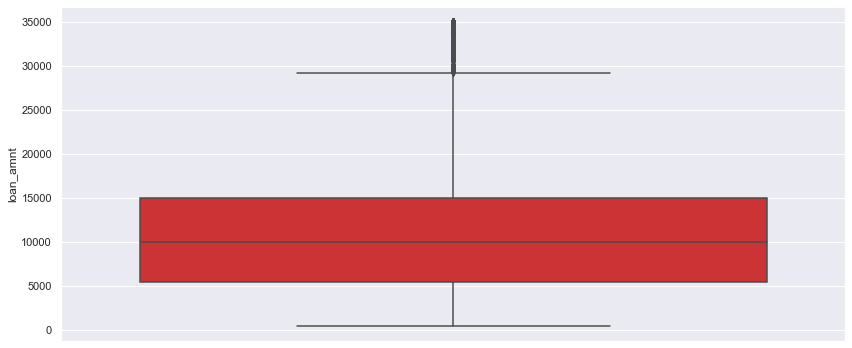

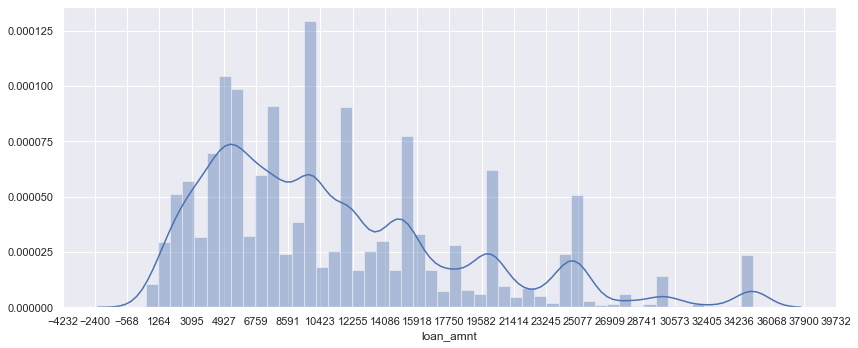

In [1178]:
univariate_analysis('loan_amnt')

As we can see there are some outliers in the `loan_amnt`. However, we can't remove these as they may be the defaulted one. We can create a new categorical column `loan_amnt_type` which categorizes the loans as **low, medium and high**

In [1179]:
def add_categorical_column(df,
                           bins,
                           column,
                           new_column,
                           interval,
                           verbose=True):
    interval.append(df[column].max() + 1)
    df[new_column] = pd.cut(df[column], interval, right=False, labels=bins)
    if verbose:
        print(df[[column, new_column]].head())

In [1180]:
add_categorical_column(loans, ['low', 'medium', 'high'], 'loan_amnt',
                       'loan_amnt_type', [0, 5000, 15000])

   loan_amnt loan_amnt_type
0       5000         medium
1       2500            low
2       2400            low
3      10000         medium
5       5000         medium


count      36735
unique         3
top       medium
freq       19741
Name: loan_amnt_type, dtype: object
mode:  0    medium
Name: loan_amnt_type, dtype: category
Categories (3, object): [low < medium < high]
medium    19741
high      10108
low        6886
Name: loan_amnt_type, dtype: int64


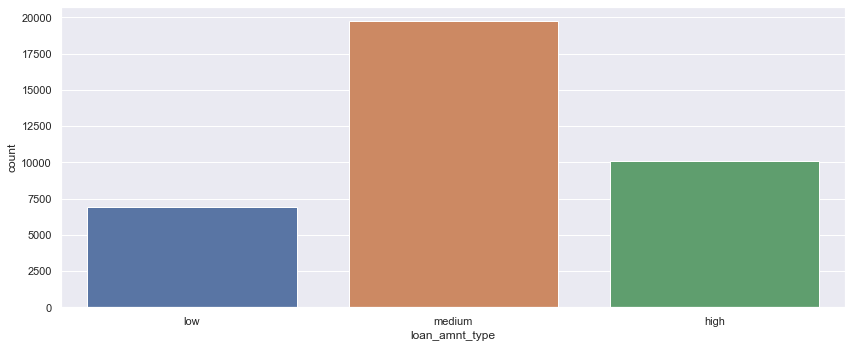

In [1181]:
univariate_analysis('loan_amnt_type', is_categorical=False)

From this, we can infer that `medium` type loans are the most given loans by Lending club

In [1182]:
loans_num = loans.select_dtypes(include=['int64','float64'])
loans_num.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,pub_rec_bankruptcies,loan_defaulted
count,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000
mean,11153.4531,10884.2317,10444.7007,324.9947,69468.9407,13.3371,0.1460,0.8689,9.3058,13384.8863,22.1627,12020.2755,11544.8782,9766.7111,2154.8479,1.3409,97.3757,12.4964,0.0417,0.1416
std,7368.3826,7107.2998,7008.0288,208.8390,64063.8854,6.6496,0.4914,1.0675,4.3760,15856.3133,11.4068,8849.6020,8705.6407,7034.1563,2412.1385,7.2043,700.4411,150.2953,0.2005,0.3487
min,500.0000,500.0000,0.0000,16.0800,4000.0000,0.0000,0.0000,0.0000,2.0000,0.0000,2.0000,33.7300,0.0000,0.0000,6.2200,0.0000,0.0000,0.0000,0.0000,0.0000
25%,5500.0000,5425.0000,5000.0000,167.7300,41200.0000,8.2200,0.0000,0.0000,6.0000,3734.5000,14.0000,5590.5861,5292.7300,4641.2650,660.7750,0.0000,0.0000,0.0000,0.0000,0.0000
50%,10000.0000,9600.0000,9000.0000,280.2800,60000.0000,13.4300,0.0000,1.0000,9.0000,8880.0000,20.0000,9832.2917,9375.5800,8000.0000,1328.6800,0.0000,0.0000,0.0000,0.0000,0.0000
75%,15000.0000,15000.0000,14353.3263,429.4500,83000.0000,18.5900,0.0000,1.0000,12.0000,17035.5000,29.0000,16322.6987,15637.7650,13500.0000,2720.6600,0.0000,0.0000,0.0000,0.0000,0.0000
max,35000.0000,35000.0000,35000.0000,1305.1900,6000000.0000,29.9900,11.0000,8.0000,44.0000,149588.0000,90.0000,58563.6799,58563.6800,35000.0200,23563.6800,180.2000,29623.3500,7002.1900,2.0000,1.0000


In [1183]:
loans['term'].value_counts()

 36 months    27496
 60 months     9239
Name: term, dtype: int64

As we can see `term` has two values. `term` is a ordinal categorical variable. We can create a new column `is_short_term` which will have *1* for `36 months` and *0* for `60 months`

In [1184]:
loans['is_short_term'] = loans['term'].apply(lambda x : 1 if x == '36 months' else 0)

In [1185]:
loans['int_rate'] = loans['int_rate'].str.replace('%',"").astype(float)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7facdf7a7410>]],
      dtype=object)

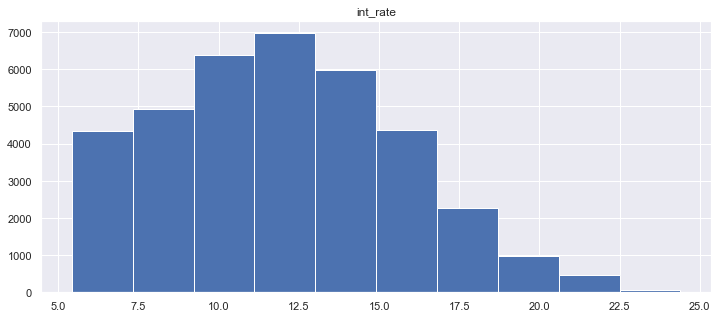

In [1186]:
loans.hist('int_rate', bins=10)

In [1187]:
def get_interest_slab(interest):
    if interest < 10:
        return 'low'
    elif interest >= 10 and interest < 17.5:
        return 'medium'
    else:
        return 'high'

As we can see `int_rate` is a continuous variable, we are creating a new categorical variable for analysis with following slabs:

- interest < 10, will be low
- interest < 17.5, will be medium
- otherwise it will be marked as high


In [1188]:
loans['int_rate_slab'] = loans['int_rate'].apply(get_interest_slab)

In [1189]:
loans['emp_length'].value_counts()

10+ years    8359
< 1 year     4322
2 years      4194
3 years      3940
4 years      3283
5 years      3147
1 year       3062
6 years      2132
7 years      1685
8 years      1405
9 years      1206
Name: emp_length, dtype: int64

As we can, `emp_length` has 11 distinct values, this can be treated as ordinal categorical variable

In [1190]:
loans['emp_length'] = loans['emp_length'].apply(
    lambda x: x.replace(' years', "").replace(' year', "").replace(
        "+", "").replace("< 1", "0")).astype(int)

In [1191]:
loans['annual_inc'].value_counts()

60000.0000    1408
50000.0000     992
40000.0000     823
45000.0000     771
75000.0000     760
              ... 
81972.0000       1
9840.0000        1
39359.0000       1
34416.0000       1
8472.0000        1
Name: annual_inc, Length: 4932, dtype: int64

In [1192]:
loans['annual_inc'].describe()

count     36735.0000
mean      69468.9407
std       64063.8854
min        4000.0000
25%       41200.0000
50%       60000.0000
75%       83000.0000
max     6000000.0000
Name: annual_inc, dtype: float64

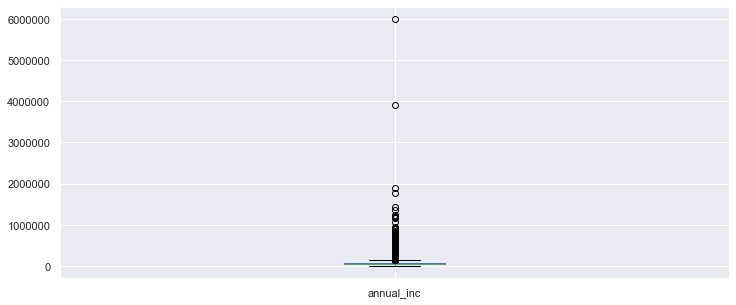

In [1193]:
loans.boxplot('annual_inc')

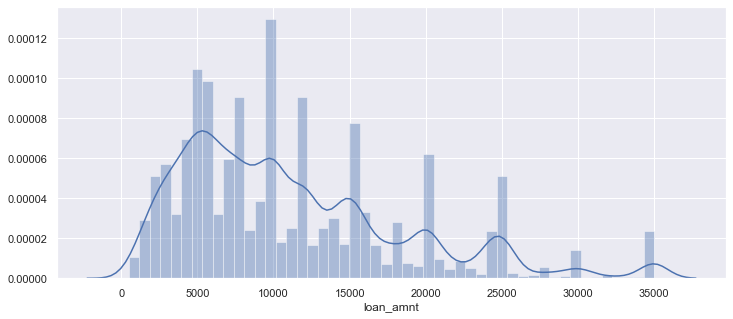

In [1194]:
sns.distplot(loans['loan_amnt'])

As we can see there are clear outliers in the salary, let us remove the outliers in the salary

In [1195]:
def get_lower_upper_bound(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)

    iqr = q3-q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return lower_bound, upper_bound

In [1196]:
def get_outlier_iqr(data):
    lower, upper = get_lower_upper_bound(data)
    return data[np.where((data > upper) | (data < lower))]


In [1197]:
#getting salary IQR lower and upper

lower_income, upper_income = get_lower_upper_bound(loans['annual_inc'].values)

In [1198]:
loans[((loans['annual_inc']>upper_income)|(loans['annual_inc']<lower_income))&(loans['loan_defaulted']==1)][['loan_amnt','annual_inc','loan_defaulted','title','purpose']]





KeyError: "['title'] not in index"

In [ ]:
c_palette = ['tab:green', 'tab:red']
categorical_summarized(loans, x = 'term', hue='loan_defaulted', palette=c_palette)

In [ ]:
colors_list = ['#5cb85c','#5bc0de']
test = loans[['emp_length','loan_defaulted']]
test = pd.crosstab(test.emp_length, test.loan_defaulted, margins=False)

# Change this line to plot percentages instead of absolute values
ax = (test.div(test.sum(1), axis=0)).plot(kind='bar',figsize=(15,4),width = 0.8,color = colors_list,edgecolor=None)
plt.legend(labels=test.columns,fontsize= 14)
plt.title("Percentage of Respondents' Interest in Data Science Areas",fontsize= 16)

plt.xticks(fontsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(height), (x, y + height + 0.01))

In [ ]:
categorical_summarized(loans, x = 'grade', hue='loan_defaulted', palette=c_palette, figsize=(12,4))

In [ ]:
sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(x='emp_length', hue='loan_defaulted', data=loans)

In [ ]:
categorical_summarized(loans, x = 'emp_length', hue='loan_defaulted', palette=c_palette, figsize=(15,6))

As, we can see `term` has two values, we can convert it into `category`.

In [ ]:
len(loans)

In [ ]:
loans.head()

In [ ]:
sns.set(rc={'figure.figsize':(3,5)})
sns.countplot(x='loan_status',data=loans)

In [ ]:
loans['loan_status'].value_counts()

In [ ]:
ax = sns.countplot(x='loan_defaulted', data=loans)

plt.title('Distribution of  loan')
plt.xlabel('Type of loan')

total = len(loans['loan_defaulted'])
for p in ax.patches:
    print(p)
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

plt.show()

In [ ]:
sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(x='grade',data=loans.sort_values(['grade']))

In [ ]:
sns.set(rc={'figure.figsize':(6,5)})
sns.countplot(x='home_ownership',data=loans)

Changing type of columns `collections_12_mths_ex_med`, `chargeoff_within_12_mths`, `pub_rec_bankruptcies` and `tax_liens` from float to int

We can see `pub_rec_bankruptcies` has 3 values, which can be considered as Ordinal categorical variable

In [ ]:
loans['pub_rec_bankruptcies'] = loans['pub_rec_bankruptcies'].astype('category')

In [ ]:
loans_num.corr(method='kendall')

In [ ]:
sns.set(rc={'figure.figsize':(15,15)})
sns.set()
sns.heatmap(loans_num.corr(method='spearman'), annot=True, fmt='.2f', linewidths=2)

sns.set()

In [ ]:
#sns.pairplot(loans_num)

In [ ]:
loans['earliest_cr_line'].value_counts()